<a href="https://colab.research.google.com/github/nightmarewarrior/homework/blob/main/homework_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашка

### Задание 1 (8 баллов)
Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling, Dense считаются слоями, остальное нет, но их тоже можно использовать). Как минимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на Recall@Precision меру. Качество модели не должно быть околонулевым. Если метрики не растут, то попробуйте пообучать подольше или перестроить саму сеть.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц.


### Задание 2 (2 балла)
Обучите нейросеть со сверточными слоями с архитектурой похожей на Unet - https://en.wikipedia.org/wiki/U-Net

Не нужно воспроизводить все в точности, главное, чтобы было сокращение длины последовательности с помощью CNN, а затем обратное увеличение длины последовательности до изначальной с residual связями между промежуточными шагами с одинаковыми размерностями.
Изменений размерности должно быть хотя бы 3 и соответственно residual связей тоже.

Для повышения размерности используйте keras.layers.UpSampling1D
Полученная модель должна давать ненулевое качество на той же самой задаче классификации текстов.

In [1]:
!unzip lenta_40k.csv.zip

Archive:  lenta_40k.csv.zip
  inflating: lenta_40k.csv           


In [2]:
!pip install pandas scikit-learn matplotlib

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data = pd.read_csv('lenta_40k.csv')

In [5]:
data

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия
...,...,...
44351,Российский Минфин может пересмотреть минимальн...,Экономика
44352,Сотрудники Службы безопасности Украины (СБУ) с...,Бывший СССР
44353,Америке следует задуматься над поставками на У...,Силовые структуры
44354,"Опознаны тела 71 человека, погибшего в результ...",Мир


In [6]:
data.dropna(subset=['topic', 'text'], inplace=True)

In [7]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [9]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [10]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [11]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [12]:
id2word = {i:word for word, i in word2id.items()}

In [13]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [14]:
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)

In [15]:
MAX_LEN, MEAN_LEN

(200, 170.0)

In [16]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
X.shape

(44356, 200)

In [17]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [18]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [19]:
len(label2id)

19

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [21]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла
                                                monitor='val_f1', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1',
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1,
                                              mode='max',
                                              )

In [46]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)
#drop1 = tf.keras.layers.Dropout(0.3)(embeddings)
convs = []
for ks in [3,4,5,7,10]:
    conv1 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(embeddings)
    pool1 = tf.keras.layers.AveragePooling1D(2)(conv1)
    drop1 = tf.keras.layers.Dropout(0.3)(pool1)
    conv2 = tf.keras.layers.Conv1D(kernel_size=ks, filters=24, padding='same',strides=1,
                                  kernel_regularizer='l2', activation='relu')(conv1)

    pool2 = tf.keras.layers.AveragePooling1D(pool_size=2)(conv2)
    drop2 = tf.keras.layers.Dropout(0.3)(pool2)
    convs.append(drop2)


concat = tf.keras.layers.concatenate(convs, axis=2)

#conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
#flatten = tf.keras.layers.Flatten()(conv_global)
flatten = tf.keras.layers.Flatten()(concat)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [47]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_9 (Embedding)   │ (None, 200, 100)       │      2,409,200 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_94 (Conv1D)        │ (None, 200, 32)        │          9,632 │ embedding_9[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_96 (Conv1D)        │ (None, 200, 32)        │         12,832 │ embedding_9[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_98 (Conv1D)        │ (None, 200, 32)        │         16,032 │ embedding_9[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_100 (Conv1D)       │ (None, 200, 32)        │         22,432 │ embedding_9[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_102 (Conv1D)       │ (None, 200, 32)        │         32,032 │ embedding_9[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_95 (Conv1D)        │ (None, 200, 24)        │          2,328 │ conv1d_94[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_97 (Conv1D)        │ (None, 200, 24)        │          3,096 │ conv1d_96[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_99 (Conv1D)        │ (None, 200, 24)        │          3,864 │ conv1d_98[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_101 (Conv1D)       │ (None, 200, 24)        │          5,400 │ conv1d_100[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_103 (Conv1D)       │ (None, 200, 24)        │          7,704 │ conv1d_102[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_46      │ (None, 100, 24)        │              0 │ conv1d_95[0][0]        │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_48      │ (None, 100, 24)        │              0 │ conv1d_97[0][0]        │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_50      │ (None, 100, 24)        │              0 │ conv1d_99[0][0]        │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_52      │ (None, 100, 24)        │              0 │ conv1d_101[0][0]       │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_54      │ (None, 100, 24)        │              0 │ conv1d_103[0][0]       │
│ (AveragePooling1D)   

 Total params: 3,125,571 (11.92 MB)

 Trainable params: 3,125,571 (11.92 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=20,
         callbacks=[checkpoint, early_stop])

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - f1: 0.0450 - loss: 1.6377
Epoch 1: val_f1 did not improve from 0.73719
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 551ms/step - f1: 0.0445 - loss: 1.6269 - val_f1: 0.0074 - val_loss: 1.0095
Epoch 2/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - f1: 0.0022 - loss: 0.9191
Epoch 2: val_f1 did not improve from 0.73719
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - f1: 0.0021 - loss: 0.9118 - val_f1: 0.0000e+00 - val_loss: 0.6560
Epoch 3/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - f1: 0.0071 - loss: 0.6013
Epoch 3: val_f1 did not improve from 0.73719
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - f1: 0.0078 - loss: 0.5969 - val_f1: 0.0589 - val_loss: 0.4423
Epoch 4/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - f1: 0.0669 - loss: 0.4096
Epoch 4: val_f1 did not improve from 0.73719
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - f1: 0.0670 - loss: 0.4070 - val_f1: 0.1746 - val_loss: 0.3138
Epoch 5/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - f1: 0.1492 - loss: 0.

dict_keys(['f1', 'loss', 'val_f1', 'val_loss'])


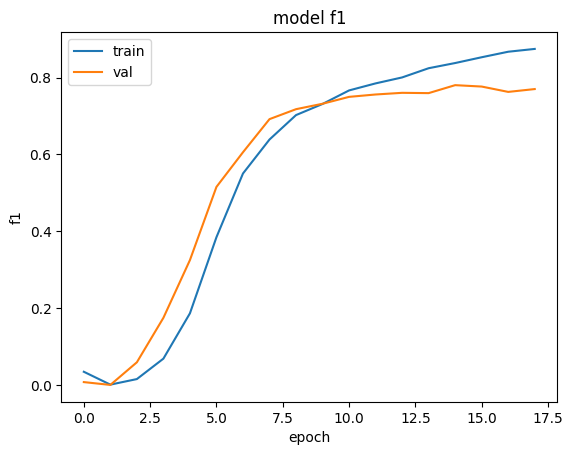

In [49]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# №2

In [43]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

l_conv_1 = tf.keras.layers.Conv1D(kernel_size=5, filters=128, strides=1,kernel_regularizer='l2',activation='relu', padding='same')(embeddings)
l_pool_1 = tf.keras.layers.MaxPooling1D(2)(l_conv_1)

l_conv_2 = tf.keras.layers.Conv1D(kernel_size=5, filters=64, strides=1,kernel_regularizer='l2',activation='relu', padding='same')(l_pool_1)
l_pool_2 = tf.keras.layers.MaxPooling1D(2)(l_conv_2)

l_conv_3 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=1,kernel_regularizer='l2',activation='relu', padding='same')(l_pool_2)
l_pool_3 = tf.keras.layers.MaxPooling1D(2)(l_conv_3)

m_conv = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1,kernel_regularizer='l2',activation='relu', padding='same')(l_pool_3)
m_up = tf.keras.layers.UpSampling1D(2)(m_conv)

r_concat_1 = tf.keras.layers.concatenate((m_up, l_conv_3), axis = -1)
r_conv_1 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=1,kernel_regularizer='l2',activation='relu', padding='same')(r_concat_1)
r_up_1 = tf.keras.layers.UpSampling1D(2)(r_conv_1)

r_concat_2 = tf.keras.layers.concatenate((r_up_1,l_conv_2), axis = -1)
r_conv_2 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1,kernel_regularizer='l2',activation='relu', padding='same')(r_concat_2)
r_up_2 = tf.keras.layers.UpSampling1D(2)(r_conv_2)

r_concat_3 = tf.keras.layers.concatenate((r_up_2,l_conv_1), axis = -1)
r_conv_3 = tf.keras.layers.Conv1D(kernel_size=5, filters=64, strides=1,kernel_regularizer='l2',activation='relu', padding='same')(r_concat_3)

flatten = tf.keras.layers.Flatten()(r_conv_3)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(flatten)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name = 'U-Net')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [44]:
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20            │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_20 (Embedding)  │ (None, 200, 100)       │      2,409,200 │ input_layer_20[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_90 (Conv1D)        │ (None, 200, 128)       │         64,128 │ embedding_20[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_60          │ (None, 100, 128)       │              0 │ conv1d_90[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_91 (Conv1D)        │ (None, 100, 64)        │         41,024 │ max_pooling1d_60[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_61          │ (None, 50, 64)         │              0 │ conv1d_91[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_92 (Conv1D)        │ (None, 50, 16)         │          5,136 │ max_pooling1d_61[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_62          │ (None, 25, 16)         │              0 │ conv1d_92[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_93 (Conv1D)        │ (None, 25, 32)         │          2,592 │ max_pooling1d_62[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling1d_21          │ (None, 50, 32)         │              0 │ conv1d_93[0][0]        │
│ (UpSampling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_19            │ (None, 50, 48)         │              0 │ up_sampling1d_21[0][0… │
│ (Concatenate)             │                        │                │ conv1d_92[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_94 (Conv1D)        │ (None, 50, 16)         │          3,856 │ concatenate_19[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling1d_22          │ (None, 100, 16)        │              0 │ conv1d_94[0][0]        │
│ (UpSampling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_20            │ (None, 100, 80)        │              0 │ up_sampling1d_22[0][0… │
│ (Concatenate)             │                        │                │ conv1d_91[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_95 (Conv1D)        │ (None, 100, 32)        │         12,832 │ concatenate_20[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling1d_23     

 Total params: 2,833,251 (10.81 MB)

 Trainable params: 2,833,251 (10.81 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=20,
         callbacks=[checkpoint, early_stop])

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - f1: 0.0263 - loss: 3.8455
Epoch 1: val_f1 improved from -inf to 0.00000, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 658ms/step - f1: 0.0262 - loss: 3.8189 - val_f1: 0.0000e+00 - val_loss: 2.0868
Epoch 2/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - f1: 0.0017 - loss: 1.7754
Epoch 2: val_f1 did not improve from 0.00000
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - f1: 0.0017 - loss: 1.7520 - val_f1: 0.0000e+00 - val_loss: 0.9772
Epoch 3/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - f1: 0.0016 - loss: 0.8392
Epoch 3: val_f1 improved from 0.00000 to 0.00656, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - f1: 0.0016 - loss: 0.8290 - val_f1: 0.0066 - val_loss: 0.4971
Epoch 4/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - f1: 0.0029 - loss: 0.4405
Epoch 4: val_f1 improved from 0.00656 to 0.02596, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - f1: 0.0033 - loss: 0.4

dict_keys(['f1', 'loss', 'val_f1', 'val_loss'])


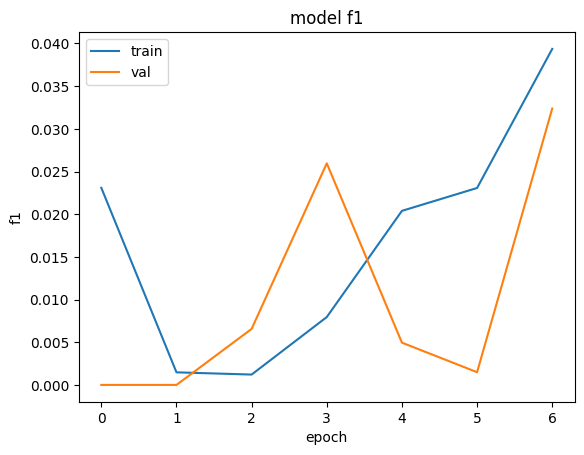

In [46]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()